In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

from pathlib import Path
import pandas as pd
import fileinput
import cartopy

In [3]:
import simpegEM1D
simpegEM1D.__path__

['/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/simpegEM1D']

In [4]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_raw_2017')
data19dir = datadir.joinpath('AEM_data_raw_2019')



data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')

In [5]:
def rm_leadspace(f_name):
    for line in fileinput.input(f_name,inplace = True):
        if line.startswith('/ '):
            print(line.lstrip('/ ').rstrip('\n'))
        else:
            print(line.rstrip('\n'))
    fileinput.close()

    
xyz_dirs = (data17.parent,data19.parent,data17dir,data19dir)

for d in xyz_dirs:
    for f in d.iterdir():
        if f.as_posix().endswith('xyz'):
            rm_leadspace(f.as_posix())

In [10]:
df17 = pd.read_csv(data17,header=20,delim_whitespace=True)
df19 = pd.read_csv(data19,header=20,delim_whitespace=True)

df17 = df17.assign(skytem_type=304)
df19 = df19.assign(skytem_type=312)
# df = pd.concat((df17,df19),sort=False)



line = 100501

header=20
for i,f in enumerate(data17dir.iterdir()):
    if i==0:
        df = pd.read_csv(f,header=header,delim_whitespace=True)
        df = df.assign(FLIGHT_NO=f.name.split('_')[0])
        df = df.assign(skytem_type=304)
    else:
        df_temp = pd.read_csv(f,header=header,delim_whitespace=True)
        df_temp = df_temp.assign(FLIGHT_NO=f.name.split('_')[0])
        df_temp = df_temp.assign(skytem_type=304)
        df = pd.concat((df,df_temp))

# for i,f in enumerate(data19dir.iterdir()):
#     if i==0:
#         df = pd.read_csv(f,header=header,delim_whitespace=True)
#         df = df.assign(FLIGHT_NO=f.name.split('_')[0])
#         df = df.assign(skytem_type=312)
#     else:
#         df_temp = pd.read_csv(f,header=header,delim_whitespace=True)
#         df_temp = df_temp.assign(FLIGHT_NO=f.name.split('_')[0])
#         df_temp = df_temp.assign(skytem_type=312)
#         df = pd.concat((df,df_temp))


In [11]:
i_start_hm = 10
i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
dbdt_inds = np.array([key.startswith('DBDT') for key in df.keys()], dtype=bool)

lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]

#### Weave in blank HM soundings into repeated LM (and LM into repeated HM)

In [12]:
df = df.reset_index()
df = df.rename(columns={'index':'index_orig'})
df.index = df.index.astype(np.float)

repeat_inds = df.CHANNEL_NO.diff()==0
repeat_channel = df.CHANNEL_NO.loc[repeat_inds].values
new_channel = np.asarray([2 if v==1 else 1 for v in repeat_channel])

repeat_info = df.loc[repeat_inds,:].copy()
repeat_info.loc[:,dbdt_inds] = 9999
repeat_info.loc[:,'CHANNEL_NO'] = new_channel

ind_list = repeat_info.index.tolist()
for i,ind in enumerate(repeat_info.index):
    ind_list[i] += -0.5
repeat_info.index = ind_list
df = df.append(repeat_info)
df = df.sort_index()


#Check beginning and end
last_ind = df.index.max()
first_ind = df.index.min()
if df.loc[last_ind].CHANNEL_NO==1:
    row = df.loc[last_ind].copy()
    row.CHANNEL_NO = 2
    row.loc[dbdt_inds] = 9999
    df.loc[last_ind+.5] = row
if df.loc[first_ind].CHANNEL_NO==2:
    row = df.loc[first_ind].copy()
    row.CHANNEL_NO = 2
    row.loc[dbdt_inds] = 9999
    df.loc[first_ind-.5] = row


Text(0.5, 1.0, 'Inverted data: flight line 100501')

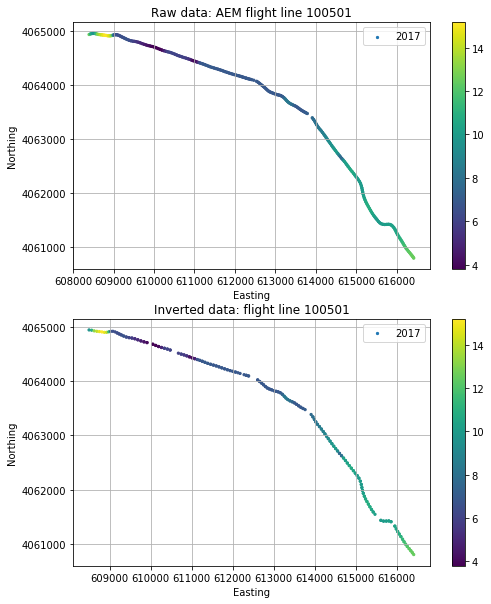

In [13]:
f,axs = plt.subplots(2,1,figsize=(8,10))
plt.sca(axs.flatten()[0])
ax = plt.gca()
plt.scatter(df.loc[df.LINE_NO==line,'UTMX'],
            df.loc[df.LINE_NO==line,'UTMY'],
            s=5,
            c=df.loc[df.LINE_NO==line,'ELEVATION'],
            label='2017')



plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Raw data: AEM flight line {}'.format(line))



plt.sca(axs.flatten()[1])
ax = plt.gca()
plt.scatter(df17.loc[df17.LINE==line,'X'],
            df17.loc[df17.LINE==line,'Y'],
            s=5,
            c=df17.loc[df17.LINE==line,'TOPO'],
            label='2017')
# plt.scatter(df19.loc[df19.LINE==line,'X'],df19.loc[df19.LINE==line,'Y'],s=1,c='k',label='2019')
plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Inverted data: flight line {}'.format(line))

In [14]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.ldf.CHANNEL_NO.isin((1,))
xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.LINE_NO.values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'TX_ALTITUDE'].values[:]
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values

In [15]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [16]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

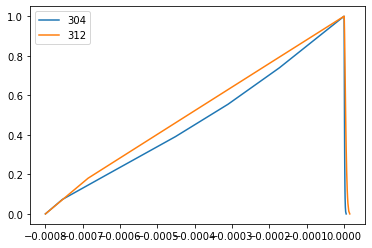

In [17]:
plt.plot(time_input_currents_LM_304, input_currents_LM_304,label='304')
plt.plot(time_input_currents_LM_312, input_currents_LM_312,label='312')
plt.legend()

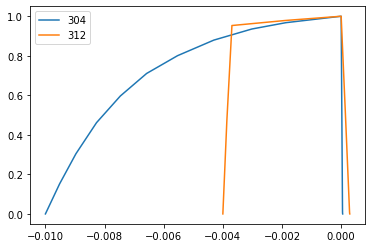

In [18]:
plt.plot(time_input_currents_HM_304, input_currents_HM_304,label='304')
plt.plot(time_input_currents_HM_312, input_currents_HM_312,label='312')
plt.legend()

##### CHeck to make sure that HM 304 is correect (look at 304 TEM files)
##### Check units (V/m2 or V/m4, dont normalize by area if V/m4)

In [19]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver
hz_312 = np.loadtxt(datadir.joinpath('AEM_data_2019','thickness.txt'))
hz_304 = np.loadtxt(datadir.joinpath('AEM_data_2017','thickness.txt'))


hz = hz_304
# hz = np.unique(hz_312.values[inds_312,:])* 0.3048
# hz = np.unique(hz_304.values[inds_304,:])* 0.3048
n_sounding = xy.shape[0]
mesh = get_2d_mesh(n_sounding, hz)

In [20]:
mesh

TensorMesh: 579,188 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     29          0.00        312.00      3.00     25.90    1.10
   y  19972          0.00     19,972.00      1.00      1.00    1.00

In [21]:
len(times_hm_304)

27

In [22]:
time = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    if skytem_type[i_sounding] == 312.:
        time.append(times_hm_312)
        time_dual_moment.append(times_lm_312)
        time_input_currents.append(time_input_currents_HM_312)
        input_currents.append(input_currents_HM_312)
        time_input_currents_dual_moment.append(time_input_currents_LM_312)
        input_currents_dual_moment.append(input_currents_LM_312)        
    else:
        time.append(times_hm_304)
        time_dual_moment.append(times_lm_304)
        time_input_currents.append(time_input_currents_HM_304)
        input_currents.append(input_currents_HM_304)
        time_input_currents_dual_moment.append(time_input_currents_LM_304)
        input_currents_dual_moment.append(input_currents_LM_304)        

In [23]:
len(time_dual_moment[0])

18

In [24]:
print(survey.nD)
print(src_locations.shape)
print(n_sounding)
print(len(time)*len(time[0]) + len(time_dual_moment)*len(time_dual_moment[0]))
print(uncert.shape)

NameError: name 'survey' is not defined

In [25]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=6,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 6


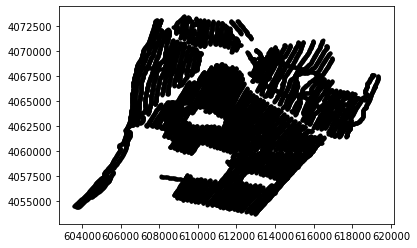

In [36]:
plt.plot(xy[:,0], xy[:,1], 'k.')

In [27]:
survey.nD

898740

n_sounding = 19972

nD_vec: 19972 long, 27 data points for each of the soundings (27*19972=539244)


nD = 539244


In [28]:
i_start_hm = 10
i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]
data_hm = df.loc[df.CHANNEL_NO==2,hm_header].values[:,:]
data_lm = df.loc[df.CHANNEL_NO==1,lm_header].values[:,:]

# dobs = np.hstack((data_hm, data_lm)).flatten() * unit_conversion

In [29]:
floor_hm = 0.
floor_lm = 0.
std = 0.05
data_hm[np.isnan(data_hm)] = 9999.
data_lm[np.isnan(data_lm)] = 9999.
dobs = np.hstack((data_hm/area, data_lm/area)).flatten()
uncert = np.hstack((abs(data_hm/area)*std + floor_hm, abs(data_lm/area)*std + floor_lm)).flatten()
survey.dobs = -dobs.copy() 
inactive_inds = dobs==9999./area
uncert[inactive_inds] = np.Inf




In [30]:
print('survey.nD size',survey.nD)
print('uncert size',uncert.size)

survey.nD size 898740
uncert size 898740


In [31]:
len(time)*len(time[0])

539244

In [32]:
uncert.size 

898740

In [33]:
mesh = get_2d_mesh(n_sounding, hz)
m0 = np.ones(mesh.nC) * np.log(1./10.)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh, mapping=regmap,
    alpha_s = 1e-2,
    alpha_x = 10.,
    alpha_y = 1.,    
)
reg.get_grad_horizontal(xy[:,:], hz, dim=3, use_cell_weights=True, minimum_distance=1000.)

np.random.seed(1)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=5, minGNiter=1, fix_Jmatrix=True,
    betaSearch=False
)
opt = Optimization.ProjectedGNCG(maxIter = 30, maxIterCG=20)
# opt.upper = m_upper
# opt.lower = m_lower
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit(chifact=0.84)
sense = Directives.UpdateSensitivityWeights()
save_model = Directives.SaveOutputDictEveryIteration(directory="./l2-m0-10ohmm-smooth/")
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model, sense])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [34]:
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Traceback (most recent call last):
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-12:


KeyboardInterrupt: 

Process ForkPoolWorker-7:
Traceback (most recent call last):
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "

In [112]:
DataMisfit

<module 'SimPEG.DataMisfit' from '/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/SimPEG/DataMisfit.py'>

In [103]:
[c for c in df17.columns]

['LINE',
 'X',
 'Y',
 'TIME',
 'FID',
 'RECORD',
 'TOPO',
 'ALT',
 'INVALT',
 'INVALTSTD',
 'DELTAALT',
 'TILT',
 'INVTILT',
 'INVTILTSTD',
 'NUMDATA',
 'SEGMENT',
 'RESDATA',
 'RESTOTAL',
 'DATA_0',
 'DATA_1',
 'DATA_2',
 'DATA_3',
 'DATA_4',
 'DATA_5',
 'DATA_6',
 'DATA_7',
 'DATA_8',
 'DATA_9',
 'DATA_10',
 'DATA_11',
 'DATA_12',
 'DATA_13',
 'DATA_14',
 'DATA_15',
 'DATA_16',
 'DATA_17',
 'DATA_18',
 'DATA_19',
 'DATA_20',
 'DATA_21',
 'DATA_22',
 'DATA_23',
 'DATA_24',
 'DATA_25',
 'DATA_26',
 'DATA_27',
 'DATA_28',
 'DATA_29',
 'DATA_30',
 'DATA_31',
 'DATA_32',
 'DATA_33',
 'DATA_34',
 'DATA_35',
 'DATA_36',
 'DATA_37',
 'DATA_38',
 'DATA_39',
 'DATA_40',
 'DATA_41',
 'DATA_42',
 'DATA_43',
 'DATA_44',
 'DATA_45',
 'DATA_46',
 'DATA_47',
 'DATASTD_0',
 'DATASTD_1',
 'DATASTD_2',
 'DATASTD_3',
 'DATASTD_4',
 'DATASTD_5',
 'DATASTD_6',
 'DATASTD_7',
 'DATASTD_8',
 'DATASTD_9',
 'DATASTD_10',
 'DATASTD_11',
 'DATASTD_12',
 'DATASTD_13',
 'DATASTD_14',
 'DATASTD_15',
 'DATASTD_16',
